In [ ]:
#Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import RocCurveDisplay, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from lime import lime_tabular

import random

In [ ]:
# Definindo uma random seed para ser utilizada em todos os modelos
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

In [ ]:
# Importando o dataset selecionado
df = pd.read_csv('harmful_asteroids.csv')

# Substituindo os valores por inteiros
df = df.replace({True: 1, False: 0})

In [ ]:
# Removendo as features que não fazem sentido para a classificação
df = df.drop(columns=['id']) # Número identificador único do asteróide
df = df.drop(columns=['name']) # Nome do asteróide
df = df.drop(columns=['orbiting_body']) # Qual planeta o asteróide está orbitando (único valor é a Terra)
df = df.drop(columns=['sentry_object']) # Se está sendo monitorado pelo sistema Sentry (todos não estão sendo monitorados)

Explicando cada feature final do dataset:

As informações são referentes a
*   **est_diameter_min**: Diâmetro mínimo estimado em quilômetros
*   **est_diameter_max**: Diâmetro máximo estimado em quilômetros
*   **relative_velocity**: Velocidade em relação à Terra
*   **miss_distance**: Distância em quilômetros perdidos
*   **absolute_magnitude**: Descreve a luminosidade intrínseca
*   **hazardous**: Mostra se o asteróide promove algum risco a nós

### Verificando o dataset

In [ ]:
df

est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
0              1.198271          2.679415       13569.249224   5.483974e+07   
1              0.265800          0.594347       73588.726663   6.143813e+07   
2              0.722030          1.614507      114258.692129   4.979872e+07   
3              0.096506          0.215794       24764.303138   2.543497e+07   
4              0.255009          0.570217       42737.733765   4.627557e+07   
...                 ...               ...                ...            ...   
90831          0.026580          0.059435       52078.886692   1.230039e+07   
90832          0.016771          0.037501       46114.605073   5.432121e+07   
90833          0.031956          0.071456        7566.807732   2.840077e+07   
90834          0.007321          0.016370       69199.154484   6.869206e+07   
90835          0.039862          0.089133       27024.455553   5.977213e+07   

       absolute_magnitude  hazardous  
0                   16.73          0  
1                   20.00          1  
2                   17.83          0  
3                   22.20          0  
4                   20.09          1  
...                   ...        ...  
90831               25.00          0  
90832               26.00          0  
90833               24.60          0  
90834               27.80          0  
90835               24.12          0  

[90836 rows x 6 columns]

Vamos remover registros duplicados e registros com valores NaN/Null/NA

In [ ]:
# Descartando duplicadas
df = df.drop_duplicates()

In [ ]:
# Descartando registros com valores NaN/Null/NA
df = df.dropna()

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df

est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
0              1.198271          2.679415       13569.249224   5.483974e+07   
1              0.265800          0.594347       73588.726663   6.143813e+07   
2              0.722030          1.614507      114258.692129   4.979872e+07   
3              0.096506          0.215794       24764.303138   2.543497e+07   
4              0.255009          0.570217       42737.733765   4.627557e+07   
...                 ...               ...                ...            ...   
90824          0.026580          0.059435       52078.886692   1.230039e+07   
90825          0.016771          0.037501       46114.605073   5.432121e+07   
90826          0.031956          0.071456        7566.807732   2.840077e+07   
90827          0.007321          0.016370       69199.154484   6.869206e+07   
90828          0.039862          0.089133       27024.455553   5.977213e+07   

       absolute_magnitude  hazardous  
0                   16.73          0  
1                   20.00          1  
2                   17.83          0  
3                   22.20          0  
4                   20.09          1  
...                   ...        ...  
90824               25.00          0  
90825               26.00          0  
90826               24.60          0  
90827               27.80          0  
90828               24.12          0  

[90829 rows x 6 columns]

Vamos analisar a distribuição de registros sobre as labels

<Axes: xlabel='hazardous', ylabel='count'>

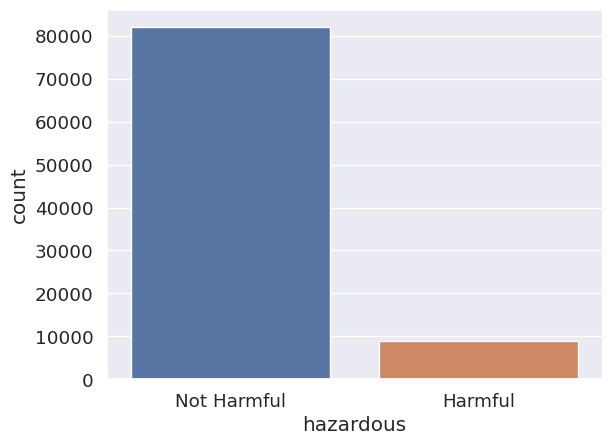

In [ ]:
sns.countplot(data=df['hazardous'].apply(lambda x: 'Harmful' if x else 'Not Harmful').to_frame(), x='hazardous')

Nota-se que a distribuição dos valores nesse dataset é bastante desigual, por isso vamos selecionar apenas uma parcela das instâncias que não possuem risco de colisão com a Terra, a fim de igualar o número de ocorrências de cada classe.

In [ ]:
# Dividindo as duas classes do dataset
df_full = df
df_H = df[df['hazardous'] == 1]
df_N = df[df['hazardous'] == 0]

# Selecionando o número de ocorrências da menor classe (Harmful)
min_ocorrencias = min(len(df_H), len(df_N))

# Selecione aleatoriamente instâncias para cada classe
df_H = df_H.sample(min_ocorrencias, random_state=random_seed)
df_N = df_N.sample(min_ocorrencias, random_state=random_seed)

# Combine os subconjuntos selecionados e embaralhando as linhas para gerar um novo dataset balanceado
df = pd.concat([df_H, df_N]).sample(frac=1, random_state=random_seed)

In [ ]:
df

est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
43962          0.055533          0.124177       68450.323555   6.763752e+07   
19704          0.166171          0.371569       51835.287277   5.133784e+07   
78150          0.105817          0.236614       58803.075165   5.119237e+07   
2340           0.050647          0.113250       71712.424481   5.516176e+07   
80203          0.038420          0.085909       25091.051986   1.307405e+07   
...                 ...               ...                ...            ...   
37728          0.146742          0.328125       47280.348502   4.691195e+07   
9075           0.040230          0.089958       51981.572042   1.154152e+07   
43031          0.378926          0.847305       57333.455664   3.051674e+07   
50828          0.555335          1.241767       59201.112695   5.018073e+07   
7896           0.415485          0.929052       99482.210392   1.627766e+07   

       absolute_magnitude  hazardous  
43962               23.40          0  
19704               21.02          0  
78150               22.00          1  
2340                23.60          0  
80203               24.20          0  
...                   ...        ...  
37728               21.29          0  
9075                24.10          0  
43031               19.23          1  
50828               18.40          1  
7896                19.03          0  

[17666 rows x 6 columns]

<Axes: xlabel='hazardous', ylabel='count'>

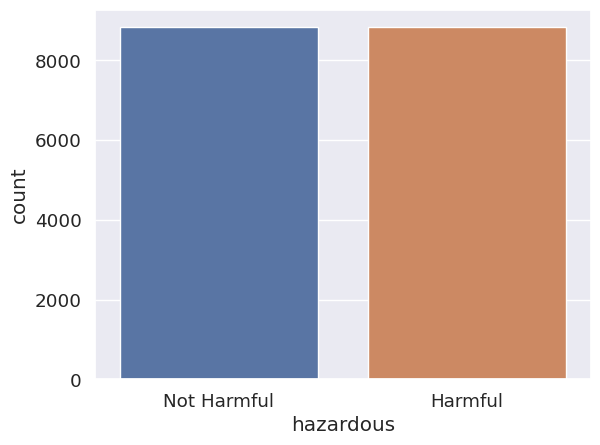

In [ ]:
# Analisando a distribuição do novo dataset
sns.countplot(data=df['hazardous'].apply(lambda x: 'Harmful' if x else 'Not Harmful').to_frame(), x='hazardous')

### Dividindo o dataset nos conjuntos de treino e teste

In [ ]:
# Dividindo o conjunto em treino e teste
X = df.drop(columns=['hazardous'])
Y = df['hazardous']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=random_seed)

### Normalizando os dados

In [ ]:
# Utilizando o StandardScaler para realizar a normalização do dataset
std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train)

norm_X_train = std_scaler.fit_transform(X_train)
norm_X_test = std_scaler.fit_transform(X_test)

# Aprendendo com kNN

In [ ]:
# Encontrando os melhores parâmetros para o kNN com GridSearch
param_grid = {'n_neighbors': list(i for i in range(5, 51, 5))}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(norm_X_train, Y_train)

best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

Melhores parâmetros encontrados: {'n_neighbors': 15}


In [ ]:
# Treinando o modelo com os melhores parâmetros e verificando a acurácia
knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
# knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(norm_X_train, Y_train)

accuracy = knn.score(norm_X_test, Y_test)
print("Acurácia do modelo kNN com melhores parâmetros:", accuracy)

Acurácia do modelo kNN com melhores parâmetros: 0.8705660377358491


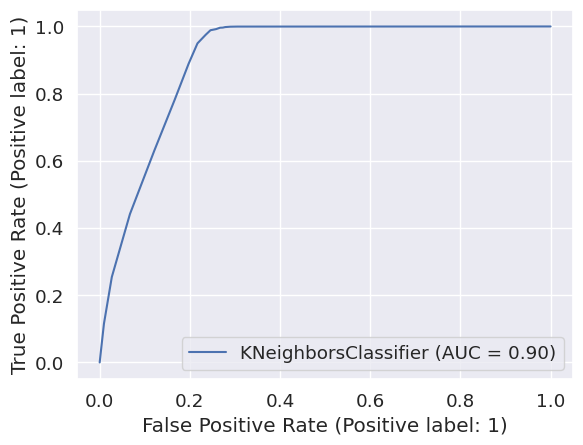

In [ ]:
#Avaliando a performance da classificação do modelo com a curva ROC
RocCurveDisplay.from_estimator(knn, norm_X_test, Y_test)

plt.show()

A curva indica que o modelo consegue distinguir eficientemente entre as classes positivas e negativas, determinando se um asteroide promove risco ou não à Terra. Isso sugere que o modelo demonstra um desempenho bom nessa capacidade de discriminação.

## Interpretabilidade do modelo kNN

### PFI

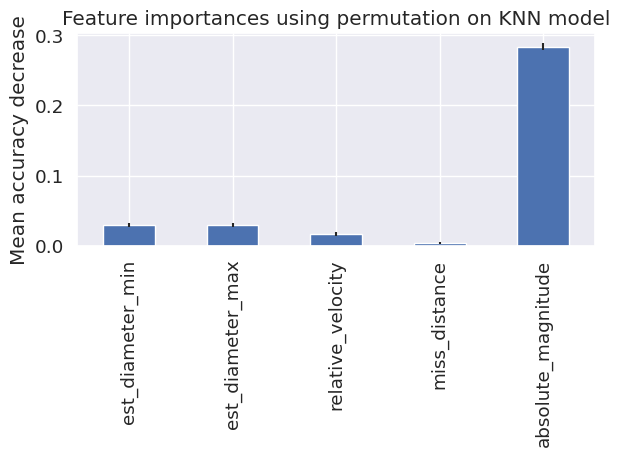

In [ ]:
# Verificando a importância de cada feature no modelo kNN utilizando PFI
result = permutation_importance(knn, norm_X_test, Y_test, n_repeats=20, random_state=random_seed)
knn_importances = pd.Series(result.importances_mean, index=X.columns)

# Plotar as importâncias das características em um gráfico de barras
fig, ax = plt.subplots()
knn_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on KNN model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Utilizando o método PFI, percebe-se que a feature mais importante para o kNN é a magnetude do asteróide (muito mais relevante que todas as demais juntas), enquanto os tamanhos mínimo e máximo estimados e a velocidade relativa com a Terra não são muito importantes, e a distância de erro não se mostrou relevante.

### PDP

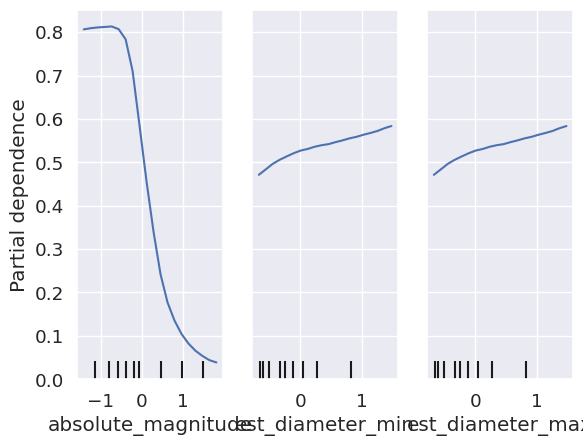

In [ ]:
# Verificando a dependência entre as features mais importantes
disp1 = PartialDependenceDisplay.from_estimator(knn, norm_X_test, [4, 0, 1], grid_resolution=20, feature_names=df.columns.tolist(), random_state=random_seed)

O gráfico de Dependência Parcial foi utilizado para avaliar como as características mais relevantes do modelo influenciam a predição de forma isolada.

O primeiro gráfico indica que a relação entre um asteroide promover risco à Terra e sua magnitude absoluta é inversamente proporcional, ou seja, quanto maior a magnitude absoluta, menor a chance do asteroide promover risco à Terra. Já o segundo e o terceiro gráfico mostra que quanto maior for o valor estimado do diametro mínimo e máximo, maior o risco do asteroide.

Percebe-se também que, assim como já foi mostrado no PFI, a variação das predições são muito mais significativas na feature de magnetude absoluta do asteróide, e são muito pouco significativas nas demais features.

### LIME

In [ ]:
# Criar um DataFrame a partir dos dados normalizados
norm_X_train_df = pd.DataFrame(norm_X_train, columns=X_train.columns)
norm_X_test_df = pd.DataFrame(norm_X_test, columns=X_test.columns)

In [ ]:
# Criando o explicador
explainer = lime_tabular.LimeTabularExplainer(norm_X_train_df.values,
                                                   feature_names= norm_X_train_df.columns,
                                                   class_names= ["Not Harmful", "Harmful"],
                                                   discretize_continuous=False)

In [ ]:
norm_X_test_df

est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
0            -0.505206         -0.505206           0.627549      -0.024645   
1            -0.692257         -0.692257          -1.451921      -0.883847   
2             0.514600          0.514600          -0.147332       0.090182   
3             0.663659          0.663659           0.994892       0.519375   
4            -0.032587         -0.032587           0.327451       0.772723   
...                ...               ...                ...            ...   
5295          0.566296          0.566296           0.178485      -0.071744   
5296         -0.614769         -0.614769          -0.432683      -0.353629   
5297         -0.539157         -0.539157           0.776537      -0.086259   
5298         -0.668558         -0.668558          -0.940963      -0.294832   
5299         -0.653931         -0.653931          -1.112976      -0.182912   

      absolute_magnitude  
0               0.445587  
1               2.484200  
2              -0.957754  
3              -1.047481  
4              -0.494759  
...                  ...  
5295           -0.990055  
5296            1.055736  
5297            0.589152  
5298            1.737666  
5299            1.486428  

[5300 rows x 5 columns]

In [ ]:
# Selecionando instâncias diferentes
instances = [2, 5297]

for i in instances:
  exp = explainer.explain_instance(norm_X_test_df.iloc[i,:], knn.predict_proba, num_features= 5, top_labels = 0)

  exp.show_in_notebook(show_table=True, show_all=True)

A instância 2 possui o valor de magnetude absoluta baixo (-0.96), por isso possui alta probabilidade de ser classificado como "Harmful". Já a instância 5297 possui o valor de magnetude absoluta alto (0.59), por isso possui alta probabilidade de ser classificado como "Not Harmful".

Ratifica-se também que os diâmetros estimados (máximo e mínimo) são menos significativos que a magnetude absuluta para a classificação de cada instância.

- obs: Os valores descritos não são os valores reais da instância, e sim os valores normalizados, por esse motivo que podem parecer bastante estranhos.

## Confiabilidade do modelo kNN

### Modelo assessor

In [ ]:
# Verificando o erro para as classes preditas pelo knn
Yhat_knn = knn.predict_proba(norm_X_test_df)[:,1]

E_knn = abs(Y_test - Yhat_knn)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# Criando um modelo assessor com decision tree
ma_dt = DecisionTreeRegressor(random_state=random_seed)
ma_dt.fit(norm_X_test_df, E_knn)

DecisionTreeRegressor(random_state=42)

Plotando um PDP sobre todas as 5 features presentes no dataset

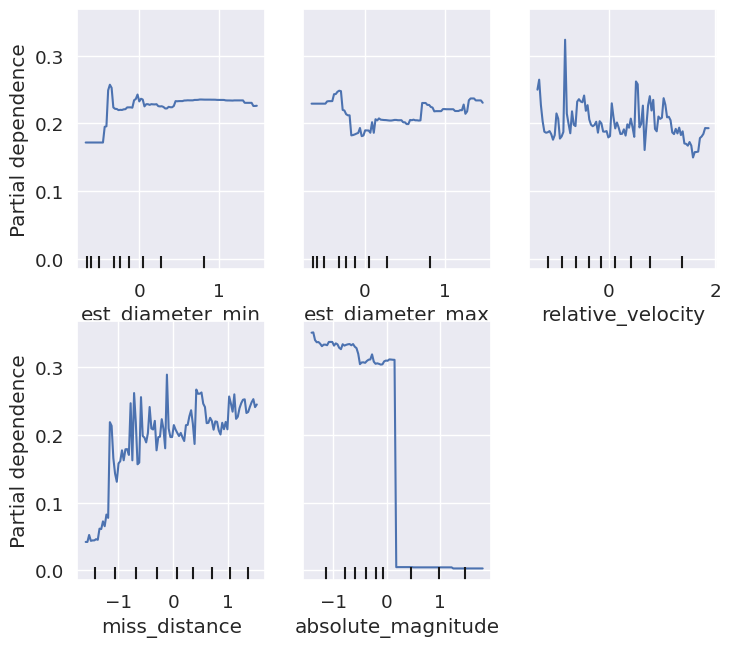

In [ ]:
# Chame a função PartialDependenceDisplay sem figsize
disp1 = PartialDependenceDisplay.from_estimator(ma_dt, norm_X_test_df, [0, 1, 2, 3, 4], random_state=random_seed)

# Defina a largura desejada da sub-figura
largura_subfigura = 20

# Ajuste as margens da sub-figura
plt.subplots_adjust(left=0, right=1, top=1.3)

# Exiba o gráfico
plt.show()

Em comparação com o modelo kNN normalizado analisado anteriormente, podemos observar que a magnitude absoluta ainda mantém uma relação semelhante, onde quanto maior o seu valor, menor a probabilidade de um asteroide representar risco para a Terra. Entretanto, essa relação agora parece menos suave, indicando uma análise mais detalhada dos valores, isso sugere que a relação entre os valores e a probabilidade de um asteroide representar risco para a Terra pode ser mais complexa do que imaginavamos.

As estimativas de diâmetro mínimo e máximo agora mostram um padrão diferente. O diâmetro mínimo exibe um pico na probabilidade de ser prejudicial para valores menores, decrescendo e mantendo-se crescente entre 0 e 1. Já o diâmetro máximo mostra oscilações na probabilidade próxima a 0, mantendo-se um pouco constante para valores maiores.


Os resultados das outras features (miss-distance e relative_velocity) tem picos e vales muito frequentes, o que pode jusitificar serem consideradas features menos importantes para o modelo.

### Matriz de confusão

In [ ]:
# Prevendo as classes de teste e criando uma matriz de confusão
knn_predictions = knn.predict(norm_X_test)
knn_cm = confusion_matrix(Y_test, knn_predictions)

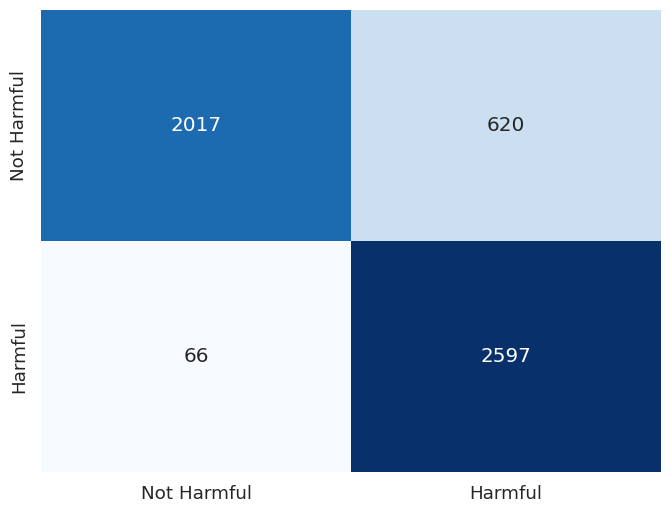

In [ ]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Crie o heatmap da matriz de confusão
sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Not Harmful', 'Harmful'], yticklabels=['Not Harmful', 'Harmful'])

# Exiba a matriz de confusão
plt.show()

Analisando a matriz de confusão do modelo kNN, percebe-se que o modelo tem muito mais facilidade em identificar asteróides que possuem risco de se colidirem com a Terra, visto que a taxa de False Positive e de True Negative são bastante satisfatórias. No entanto, a classificação do asteróide em "Sem risco" não é tão confiável, já que a quantidade de False Negative foi bastante considerável, se compararmos com a quantidade de True Positive.

Pensando numa aplicação prática, a confiabilidade não está o ideal, no entanto é muito menos prejudicial classificar um asteróide como "Risco" sendo ele realmente "Sem risco" do que classificar um asteríode como "Sem risco" sendo ele "Risco", portanto os erros não são tão graves como se fosse o caso contrário.

# Aprendendo com Random Forest

In [ ]:
param_grid = {
   'n_estimators': [100, 200, 300],
   'max_depth': [None, 5, 10, 15],
   'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=random_seed)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(norm_X_train, Y_train)
best_params = grid_search.best_params_

print("Melhores parâmetros encontrados:")
print(best_params)

Melhores parâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 200}


In [ ]:
#Treinando o Random Forest com os melhores parametros
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], criterion=best_params['criterion'], random_state=random_seed)
# rf = RandomForestClassifier(criterion='gini', max_depth=15, n_estimators=100)
rf.fit(norm_X_train, Y_train)

accuracy = rf.score(norm_X_test, Y_test)
print("Acurácia do modelo kNN com melhores parâmetros:", accuracy)

Acurácia do modelo kNN com melhores parâmetros: 0.8794339622641509


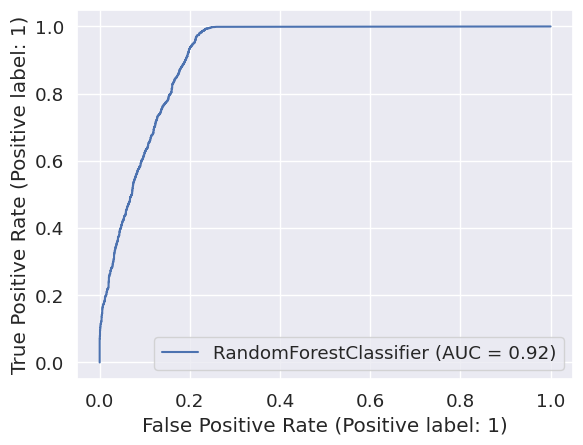

In [ ]:
#Avaliando a performance da classificação do modelo com a curva ROC

RocCurveDisplay.from_estimator(rf, norm_X_test, Y_test)

plt.show()

## Interpretabilidade do modelo Random Forest

### PFI

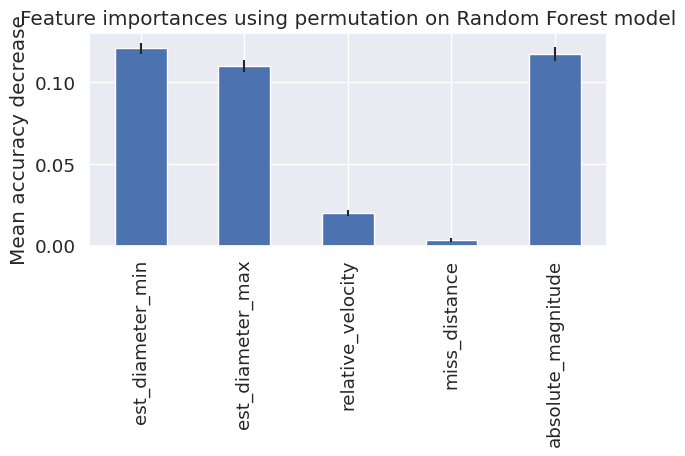

In [ ]:
#Calculando a importância das features no modelo Random Forest
result = permutation_importance(rf, norm_X_test, Y_test, n_repeats=30, random_state=random_seed)
forest_importances = pd.Series(result.importances_mean, index=X.columns)

# Plotar as importâncias das características em um gráfico de barras
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on Random Forest model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Realizando uma Permutation Feature Importance no modelo Random Forest nota-se que, diferente do modelo kNN, as features possuem uma importãncia mais balanceada, principalmente a magnetude absoluta, os diâmetros estimados mínimo e máximo. No entanto, assim como no kNN, a velocidade relativa e a distância de erro se manteve com uma importância muito pequena na classificação final.

### PDP

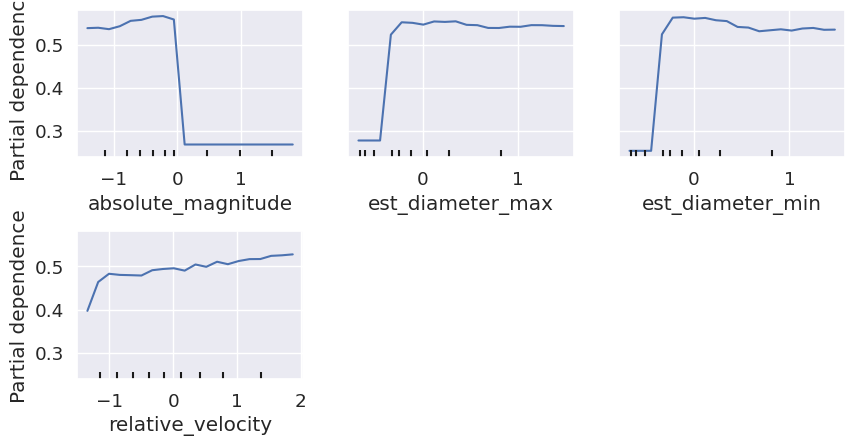

In [ ]:
# Verificando a dependência entre as features mais importantes
disp1 = PartialDependenceDisplay.from_estimator(rf, norm_X_test, [4, 1, 0, 2], grid_resolution=20, feature_names=df.columns.tolist(), random_state=random_seed)

# Ajuste as margens da sub-figura
plt.subplots_adjust(left=0, right=1.2, hspace=0.5)

# Exiba o gráfico
plt.show()

Ao analisarmos o gráfico de dependência parcial podemos perceber que assim como no kNN a magnetude absoluta influencia positivamente para o risco de um arteróide se chocar com a terra quando possui valores menores, no entanto é um pouco menos sutil que no kNN.

Também percebemos que quando o diâmetro estimado (tanto máximo quanto mínimo) é baixo a chance de o arteróide promover um risco para a Terra é bastante reduzida, no entanto com diâmetros estimados mais altos a chance de risco também se mostra superior.

Já a velocidade relativa do asteróide com a Terra altera a chance de promover um risco de forma mais suave, de forma diretamente proporcional.

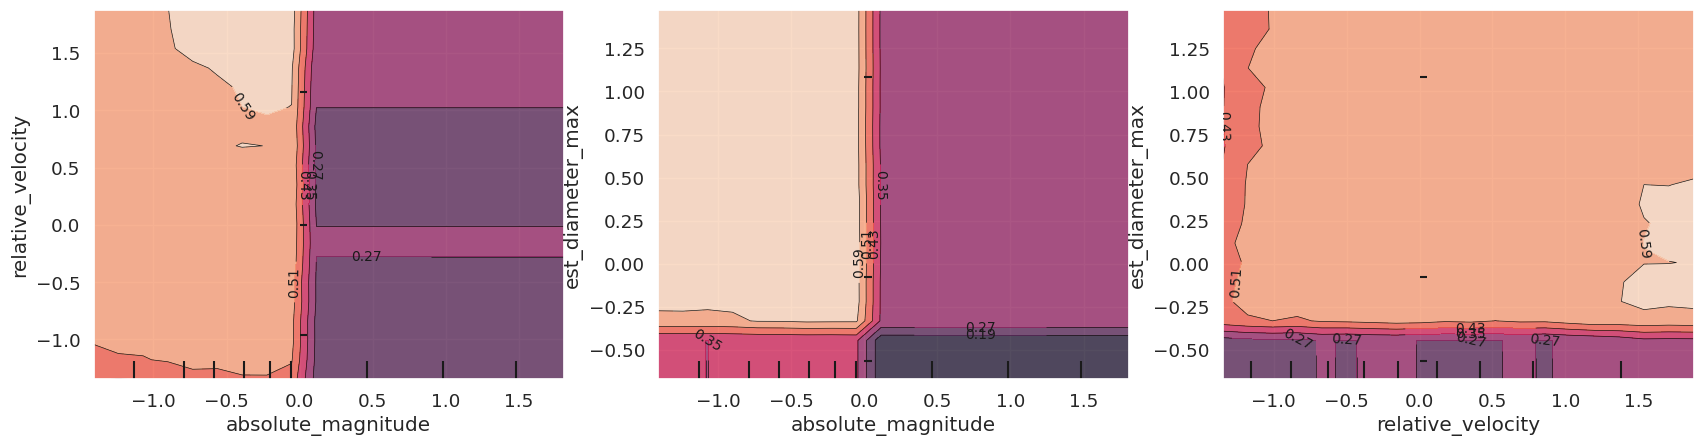

In [ ]:
disp1 = PartialDependenceDisplay.from_estimator(rf, norm_X_test, [(4, 2), (4, 1), (2, 1)], grid_resolution=20, feature_names=df.columns.tolist(), random_state=random_seed)

# Ajuste as margens da sub-figura
plt.subplots_adjust(left=0, right=2.5)

# Exiba o gráfico
plt.show()

A relação entre a magnitude absoluta e a velocidade relativa demonstra que a velocidade do asteroide não exerce tanta influência em sua periculosidade quando comparada à magnitude absoluta. Esta última, como já observado, tem maior relevância no modelo. Adicionalmente, o padrão de quanto menor a magnitude absoluta, maior a probabilidade de perigo, permanece constante independentemente do valor da velocidade relativa.

A relação entre o diâmetro máximo e a magnitude é notavelmente semelhante. Entretanto, é evidente que o diâmetro máximo desempenha um papel significativo, influenciando a magnitude quando apresenta valores menores. Portanto, quanto menor for o valor do diâmetro máximo, mesmo com uma magnitude baixa, menor é a probabilidade de o asteroide representar um perigo.

Ao considerarmos o diâmetro máximo estimado em relação à velocidade relativa, observamos que o diâmetro tem maior relevância no gráfico. Ele indica que, quanto menor o seu valor, menor é a probabilidade de o asteroide representar uma ameaça, quase independentemente da velocidade relativa. No entanto, é perceptível que, quando a velocidade é muito baixa e o diâmetro máximo não é tão reduzido, a probabilidade de o asteroide representar um perigo para a Terra é ainda maior.

### LIME

In [ ]:
# Selecionando instâncias diferentes
instances = [2, 5297]

for i in instances:
  exp = explainer.explain_instance(norm_X_test_df.iloc[i,:], rf.predict_proba, num_features= 5, top_labels = 0)

  exp.show_in_notebook(show_table=True, show_all=True)

A instância 2 possui valores de magnetude absoluta baixo (-0.96), e diâmetros altos (mínimo: 0.51) (máximo: 0.51), por isso foi prevista com alta probabilidade de ser "Harmful". Já a instância 5297 possui valores de magnetude absoluta alto (0.59) e diâmetros baixos (mínimo: -0.54) (máximo: -0.54), por isso possui alta probabilidade de ser predita como "Not Harmful".

- obs: Os valores descritos não são os valores reais da instância, e sim os valores normalizados, por esse motivo que podem parecer bastante estranhos.

## Confiabilidade do modelo Random Forest

### Modelo assessor

In [ ]:
# Verificando o erro para as classes preditas pelo random forest
Yhat_rf = rf.predict_proba(norm_X_test_df)[:,1]

E_rf = abs(Y_test - Yhat_rf)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# Criando um modelo assessor com decision tree
ma_dt = DecisionTreeRegressor(random_state=random_seed)
ma_dt.fit(norm_X_test_df, E_rf)

DecisionTreeRegressor(random_state=42)

Plotando um PDP sobre todas as 5 features do dataset

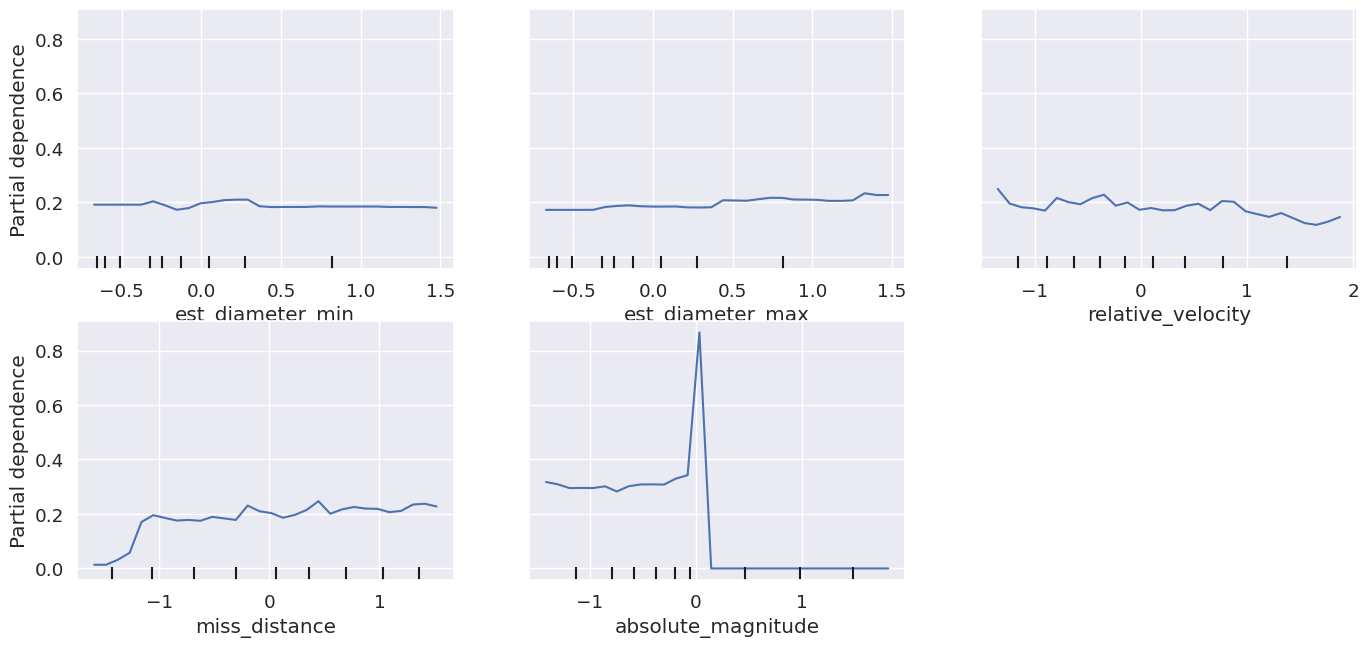

In [ ]:
# Chame a função PartialDependenceDisplay sem figsize
disp1 = PartialDependenceDisplay.from_estimator(ma_dt, norm_X_test_df, [0, 1, 2, 3, 4], grid_resolution=30, feature_names=df.columns.tolist(), random_state=random_seed)

# Defina a largura desejada da sub-figura
largura_subfigura = 20

# Ajuste as margens da sub-figura
plt.subplots_adjust(left=0, right=2, top=1.3)

# Exiba o gráfico
plt.show()

Em relação ao modelo de Random Forest analisado antes, podemos observar que os diametros mínimo e máximo estimulados mudaram drasticamente a forma como impactam a previsão do modelo, antes quanto maior o valor de ambos, menor a probabilidade do asteroide ser prejudicial, até chegar em um valor de probabilidade quase constante. Agora, o valor do parametro minimo não se mostra realmente relevante para a classificação do asteróide.

Outra feature que apresentou uma diferença drastica foi a magnitude absoluta, no modelo assessor a probabilidade de um asteroide apresentar perigo para a Terra se mostrou um pouco superior em valores baixos e inferior em valores mais altos, tendo um um grande pico em valores próximos a 0 (valores intermediários).

Os resultados das outras features (miss-distance e relative_velocity) tem variações muito frequentes, o que pode jusitificar serem consideradas features menos importantes para o modelo.

### Matriz de confusão

In [ ]:
# Prevendo as classes de teste e criando uma matriz de confusão
rf_predictions = rf.predict(norm_X_test)
rf_cm = confusion_matrix(Y_test, rf_predictions)

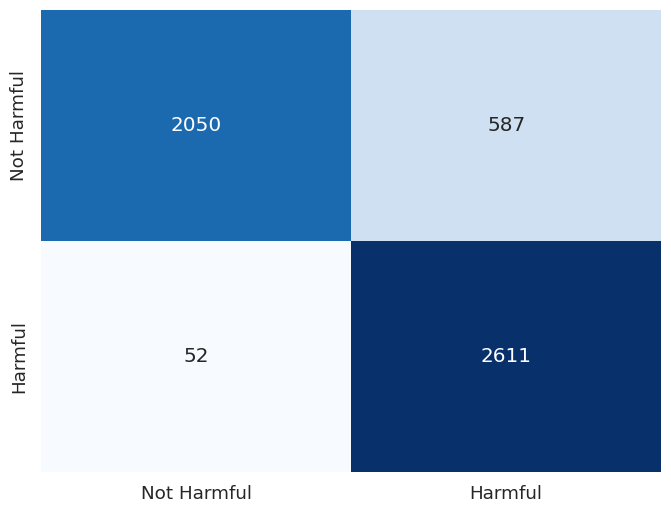

In [ ]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Crie o heatmap da matriz de confusão
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Not Harmful', 'Harmful'], yticklabels=['Not Harmful', 'Harmful'])

# Exiba a matriz de confusão
plt.show()

Ao analisarmos a matriz de confusão do modelo Random Forest podemos notar uma grande semelhança com a matriz de confusão do modelo kNN, onde o número de instâncias previstas como "Sem risco" porém que possuem algum risco são muito reduzidas, já a quantidade de instâncias previstas como "Risco" e que não possuem algum risco é um valor considerável.

# Confiabilidade com o dataset completo

Vamos criar um modelo de decision tree e treiná-lo com o dataset por inteiro, para verificarmos como o desbalanceamento (90/10) implica na confiança do modelo.

In [ ]:
# Dividindo o conjunto em treino e teste
X_full = df_full.drop(columns=['hazardous'])
Y_full = df_full['hazardous']

In [ ]:
# Dividindo o dataset completo em treino e teste
X_train_full, X_test_full, Y_train_full, Y_test_full = train_test_split(X_full, Y_full, test_size=0.3, random_state=random_seed)

In [ ]:
# Utilizando o StandardScaler para realizar a normalização do dataset
std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train_full)

norm_X_train_full = std_scaler.fit_transform(X_train_full)
norm_X_test_full = std_scaler.fit_transform(X_test_full)

In [ ]:
# Verificando os melhores parâmetros para a decision tree
param_grid = {
   'criterion': ["gini", "entropy", "log_loss"],
   'max_depth': list(i for i in range(1, 10))
}

dt = DecisionTreeClassifier(random_state=random_seed)

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(norm_X_train_full, Y_train_full)
best_params = grid_search.best_params_

print("Melhores parâmetros encontrados:")
print(best_params)

Melhores parâmetros encontrados:
{'criterion': 'gini', 'max_depth': 4}


In [ ]:
# Treinando uma decision tree com o dataset completo
dt = DecisionTreeClassifier(criterion=best_params['criterion'], max_depth=best_params['max_depth'], random_state=random_seed)
dt.fit(norm_X_train_full, Y_train_full)

accuracy = dt.score(norm_X_test_full, Y_test_full)
print("Acurácia do modelo decision tree:", accuracy)

Acurácia do modelo decision tree: 0.9100884436126097


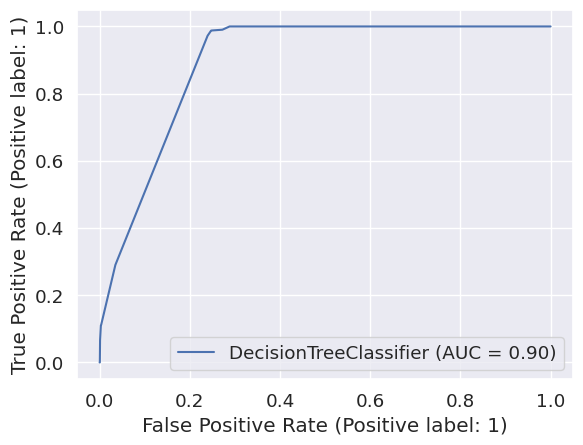

In [ ]:
#Avaliando a performance da classificação do modelo com a curva ROC
RocCurveDisplay.from_estimator(dt, norm_X_test_full, Y_test_full)

plt.show()

In [ ]:
dt_predictions = dt.predict(norm_X_test_full)
dt_cm = confusion_matrix(Y_test_full, dt_predictions)

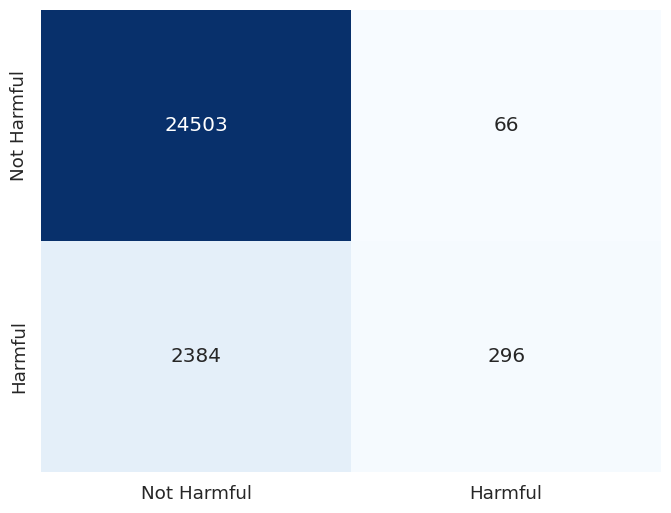

In [ ]:
# Criando a matriz de confusão

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(dt_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Not Harmful', 'Harmful'], yticklabels=['Not Harmful', 'Harmful'])

plt.show()

Verificando todos os resultados obtidos por esse modelo de decision tree treinado sobre o dataset completo, que está bastante desbalanceado, podemos perceber que a accuracy e a curva ROC estão com valores bastante satisfatórios, no entanto esses valores escondem por detrás as consequências do desbalanceamento do dataset.

Esses problemas podem ser identificados ao analisarmos a matriz de confusão resultante para o modelo, onde podemos perceber que o fato de ~90% das instâncias possuirem a classe "Not Harmful" cria uma tendência ao modelo classificar quase tudo como "Not Harmful" (Se classificar tudo como "Not Harmful" vai ter ~90% de accuracy). Portanto, percebe-se que balancear o esse dataset foi essencial para o bom funcionamento dos modelos treinados.